In [1]:
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from config import configurations

cfg = configurations[1]
TRAIN = cfg['TRAIN_PATH']
VAL = cfg['VAL_PATH']
TARGET_SIZE = cfg['TARGET_SIZE']
BATCH_SIZE = cfg['BATCH_SIZE']
EPOCHS = cfg['EPOCHS']
INPUT_SHAPE = cfg['INPUT_SHAPE']

CHECK_POINT = cfg['CHECK_POINT']
MODEL_SAVE_PATH = cfg['MODEL_SAVE_PATH']

print("=" * 60)
print("Overall Configurations:")
print(cfg)
print("=" * 60)

C:\Users\Hyuntaek\miniconda3\envs\face_recognition\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Overall Configurations:
{'TRAIN_PATH': 'faces/K-Face_all/train', 'VAL_PATH': 'faces/K-Face_all/val', 'TEST_PATH': 'faces/K-Face_all/test', 'BATCH_SIZE': 32, 'EPOCHS': 30, 'TARGET_SIZE': (224, 224), 'INPUT_SHAPE': (224, 224, 3), 'CHECK_POINT': 'Checkpoint/all/cp.ckpt', 'MODEL_SAVE_PATH': 'Model/all'}


In [2]:
# Data preparing


classes = os.listdir(TRAIN)

train_image_generator = ImageDataGenerator(
    rescale=1./255)  # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TRAIN,
                                                           shuffle=True,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='categorical')
val_data_gen = val_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                       directory=VAL,
                                                       shuffle=True,
                                                       target_size=TARGET_SIZE,
                                                       class_mode='categorical')

num_of_samples = train_data_gen.samples
print(num_of_samples)

Found 24918 images belonging to 800 classes.
Found 8232 images belonging to 800 classes.
24918


In [3]:
# Image displaying

sample_training_images, _ = next(train_data_gen)

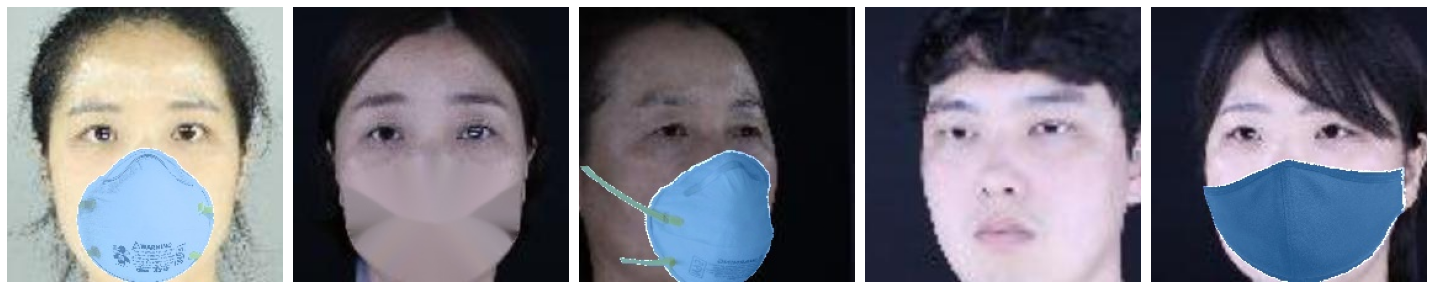

In [4]:
def plot_images(img_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()

    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_images(sample_training_images[:5])

In [5]:
model = Sequential()
model.add(MobileNetV2(input_shape=INPUT_SHAPE,
                      include_top=False,
                      weights='imagenet'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(800, activation='softmax'))

In [6]:
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.85),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 800)               820000    
Total params: 4,389,728
Trainable params: 4,355,616
Non-trainable params: 34,112
_________________________________________________________________


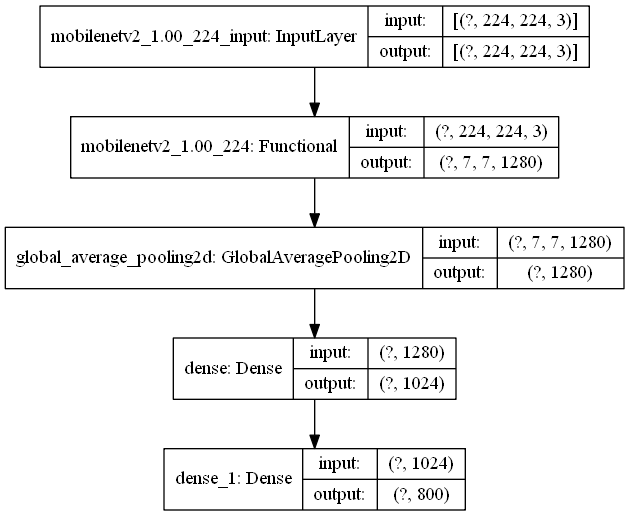

In [8]:
plot_model(model, show_shapes=True)

In [9]:
stop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(CHECK_POINT, monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1, save_best_only=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar()
# callbacks = [stop, checkpoint, tqdm_callback]
callbacks = [checkpoint]

In [10]:
history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    steps_per_epoch=int(num_of_samples/BATCH_SIZE),
                    callbacks=callbacks,
                    epochs=EPOCHS)

Epoch 1/30
778/778 [==============================] - ETA: 0s - loss: 5.5720 - accuracy: 0.1294
Epoch 00001: val_accuracy improved from -inf to 0.01786, saving model to Checkpoint/all\cp.ckpt
778/778 [==============================] - 158s 203ms/step - loss: 5.5720 - accuracy: 0.1294 - val_loss: 5.8092 - val_accuracy: 0.0179
Epoch 2/30
778/778 [==============================] - ETA: 0s - loss: 1.9089 - accuracy: 0.7737
Epoch 00002: val_accuracy improved from 0.01786 to 0.23214, saving model to Checkpoint/all\cp.ckpt
778/778 [==============================] - 131s 168ms/step - loss: 1.9089 - accuracy: 0.7737 - val_loss: 3.8375 - val_accuracy: 0.2321
Epoch 3/30
778/778 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.8481
Epoch 00003: val_accuracy improved from 0.23214 to 0.77855, saving model to Checkpoint/all\cp.ckpt
778/778 [==============================] - 132s 169ms/step - loss: 1.0995 - accuracy: 0.8481 - val_loss: 1.5064 - val_accuracy: 0.7785
Epoch 4/30
77

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

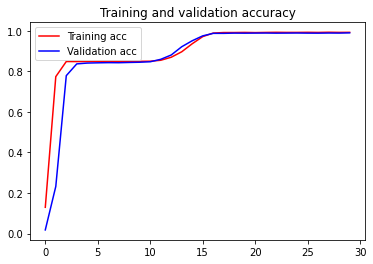

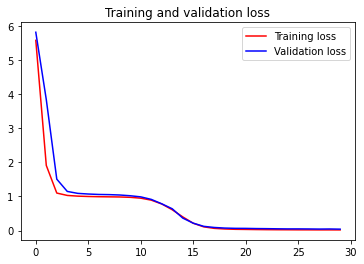

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.save(MODEL_SAVE_PATH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model/all\assets


In [14]:
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from config import configurations

cfg = configurations[1]
TEST = cfg['TEST_PATH']

TARGET_SIZE = cfg['TARGET_SIZE']
BATCH_SIZE = cfg['BATCH_SIZE']
EPOCHS = cfg['EPOCHS']
INPUT_SHAPE = cfg['INPUT_SHAPE']

MODEL_SAVE_PATH = cfg['MODEL_SAVE_PATH']

print("=" * 60)
print("Overall Configurations:")
print(cfg)
print("=" * 60)

Overall Configurations:
{'TRAIN_PATH': 'faces/K-Face_all/train', 'VAL_PATH': 'faces/K-Face_all/val', 'TEST_PATH': 'faces/K-Face_all/test', 'BATCH_SIZE': 32, 'EPOCHS': 30, 'TARGET_SIZE': (224, 224), 'INPUT_SHAPE': (224, 224, 3), 'CHECK_POINT': 'Checkpoint/all/cp.ckpt', 'MODEL_SAVE_PATH': 'Model/all'}


In [15]:
model = models.load_model(MODEL_SAVE_PATH)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 800)               820000    
Total params: 4,389,728
Trainable params: 4,355,616
Non-trainable params: 34,112
_________________________________________________________________


In [16]:
def pred(fname, target_size):
    img = image.load_img(fname, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor, dtype="float32")

    img_tensor /= 255

    img_tensor = np.expand_dims(img_tensor, axis=0)
    return img_tensor

In [17]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         directory=TEST,
                                                         shuffle=True,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='categorical')

Found 8298 images belonging to 800 classes.


In [18]:
test_class = test_data_gen.class_indices
labels = os.listdir(TEST)
y_pred = []
y_test = []
for label in tqdm(labels, desc='predict'):
    cur_path = os.path.join(TEST, label)
    for img in os.listdir(cur_path):
        x = os.path.join(cur_path, img)
        result = model.predict(pred(x, TARGET_SIZE))
        y_pred.append(np.argmax(result))
        y_test.append(test_class[label])

predict: 100%|██████████| 800/800 [04:11<00:00,  3.18it/s]


In [19]:
cm = confusion_matrix(y_test, y_pred)
norcm = cm/cm.astype(np.float).sum(axis=0)

<ipython-input-19-79a04f7a0ae2>:2: RuntimeWarning: invalid value encountered in true_divide
  norcm = cm/cm.astype(np.float).sum(axis=0)


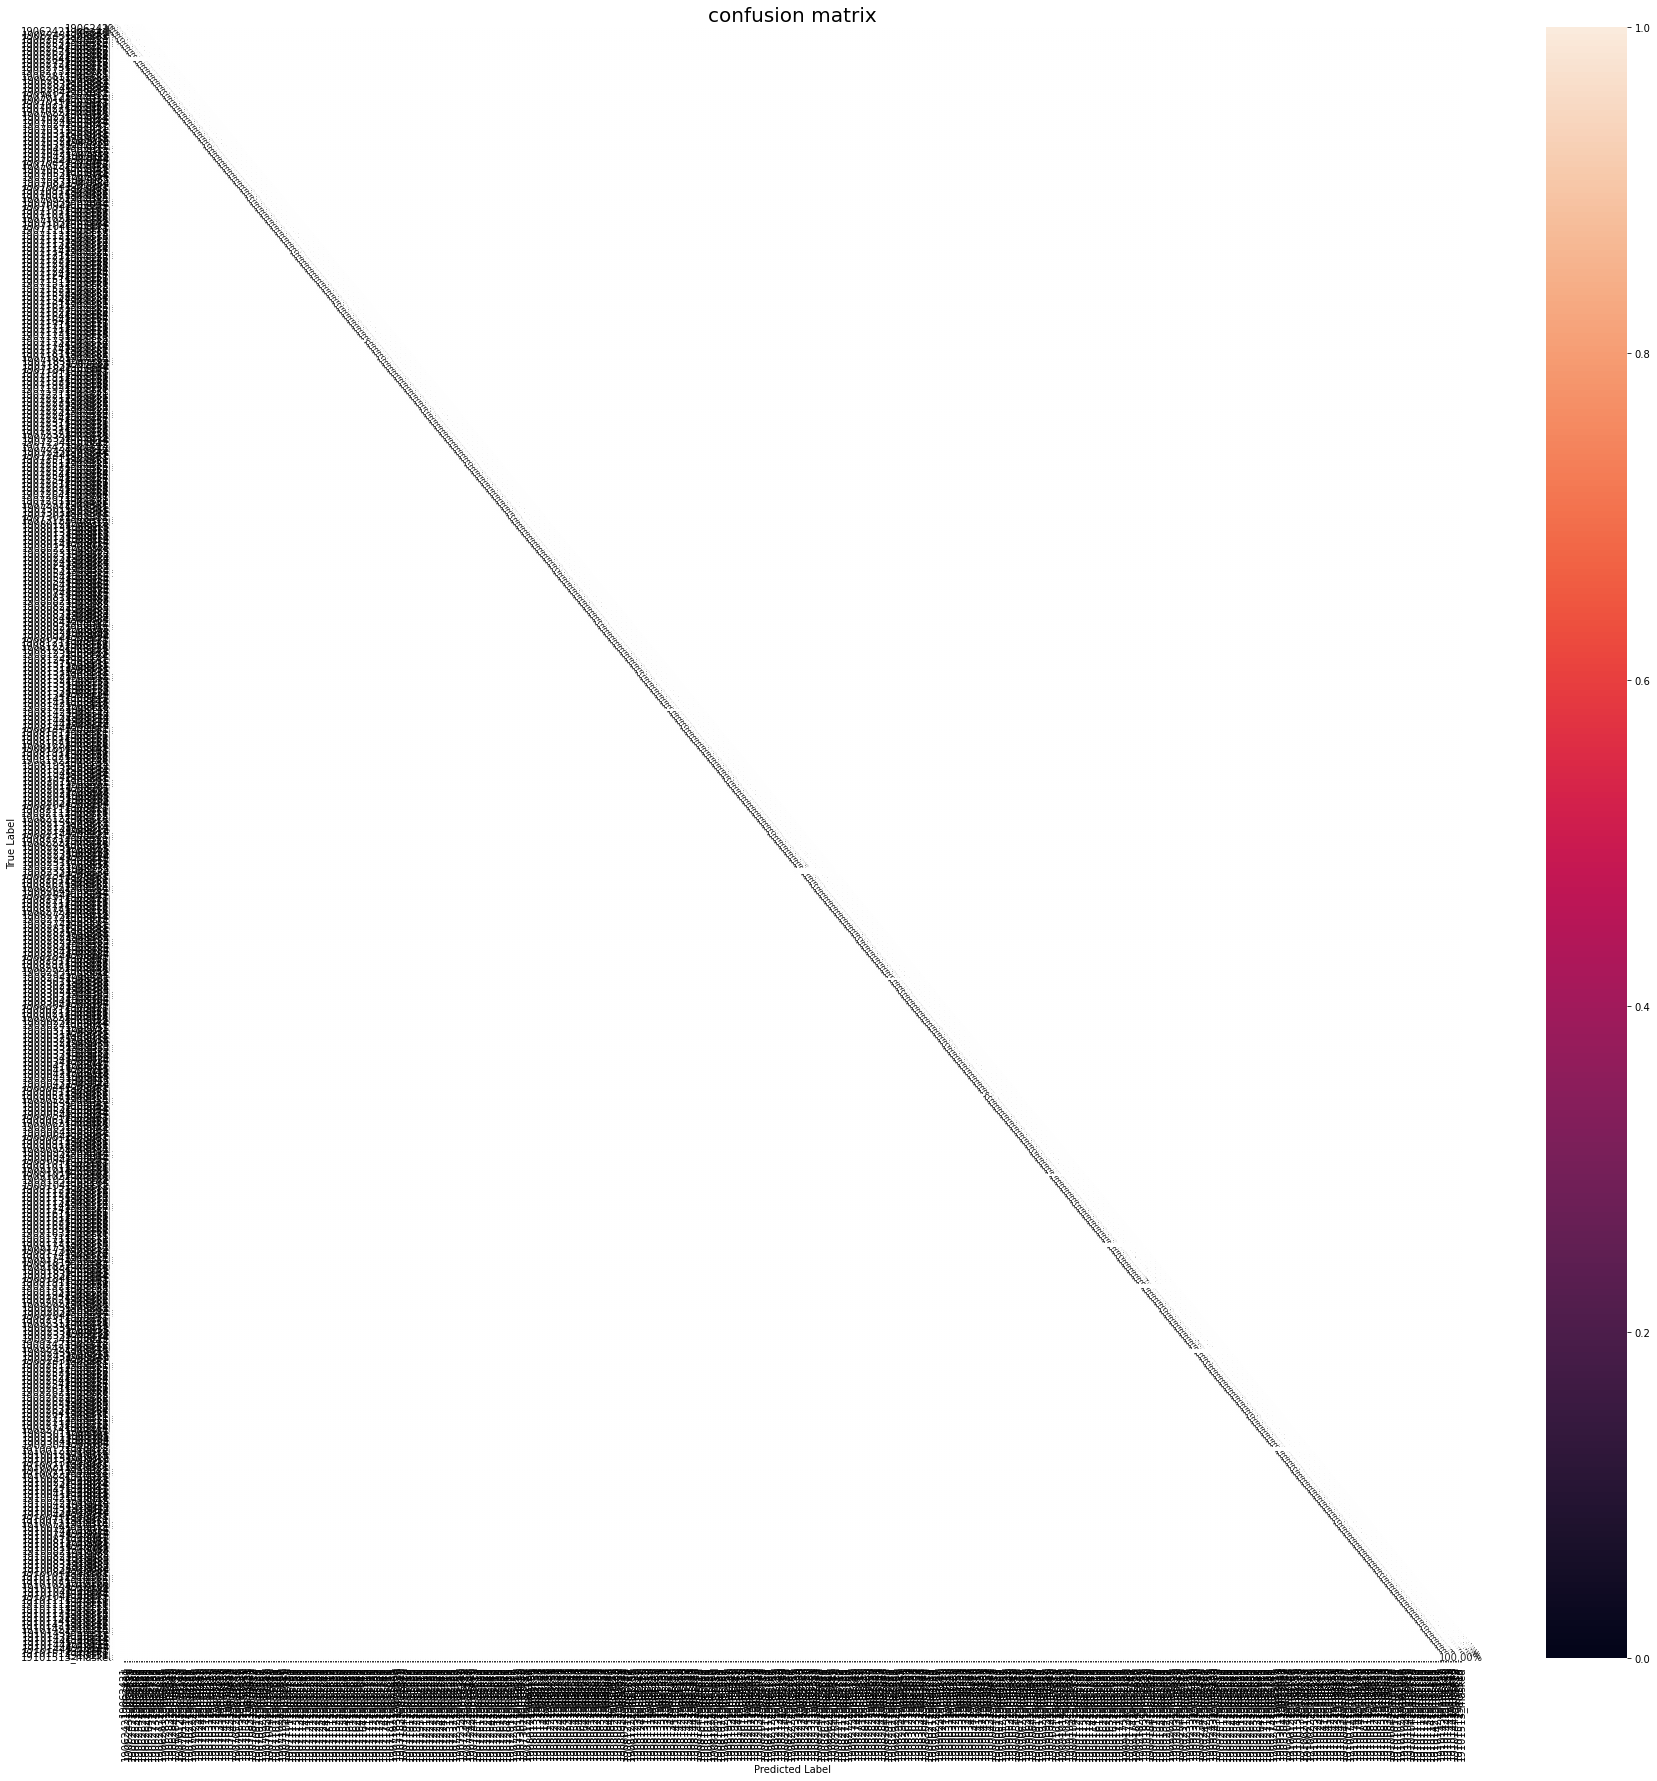

In [20]:
plt.figure(figsize=(30, 30))
sns.heatmap(norcm,  xticklabels=test_class, yticklabels=test_class,
            annot=True, fmt='.2%', linewidths=.5)
plt.title('confusion matrix', fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
print(norcm.shape)

(800, 800)


In [22]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.9916847433116414
